# Haberman Breast Cancer Survival Prediction

We're going to take the following approach:

1. Problem definition
2. Data
3. Evaluation
4. Modelling

## Problem Definition

## Data

The sample dataset is taken from Jason Brownlee's [github page](https://www.kaggle.com/datasets/slmsshk/pndm-prediction-dataset). The dataset has 3 features to be used predicting the label which is Surv_status columns in the dataset. You can see the data dictionary [here](./Data/README.md).

## Evaluation

> If we can reach 90% accuracy at predicting whether or not a patient has heart disease during the proof of concept, we'll pursue the project.

⚠️ **Note:** Due to the nature of experimentation, the evaluation metric may change over time.

## Import Libraries

We're going to use:
- [pandas](https://pandas.pydata.org/) for data analysis.
- [NumPy](https://numpy.org/) for numerical operations.
- [Matplotlib](https://matplotlib.org/) / [seaborn](https://seaborn.pydata.org/) for plotting or data visualization.
- [Scikit-Learn](https://scikit-learn.org/stable/) for machine learning modelling and evaluation.

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import seaborn as sb
sb.set_style('ticks')
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing the data
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# DNN Related Keras Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Evaluating the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
columns = ['Age', 'Op_Year', 'axil_nodes', 'Surv_status']
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv'
df = pd.read_csv(url, header=None, names=columns)
df.head()

,Age,Op_Year,axil_nodes,Surv_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


## Data Exploration (Exploratory Data Analysis - EDA)
The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.

- What question(s) are you trying to solve?
- What kind of data do we have and how do we treat different types?
- What's missing from the data and how do you deal with it?
- Where are the outliers and why should you care about them?
- How can you add, change or remove features to get more out of your data?

In [13]:
  df.shape # rows and columns

(306, 4)

In [14]:
df.describe()

,Age,Op_Year,axil_nodes,Surv_status
count,306.000000,306.000000,306.000000,306.000000
mean,52.457516,62.852941,4.026144,1.264706
std,10.803452,3.249405,7.189654,0.441899
min,30.000000,58.000000,0.000000,1.000000
25%,44.000000,60.000000,0.000000,1.000000
50%,52.000000,63.000000,1.000000,1.000000
75%,60.750000,65.750000,4.000000,2.000000
max,83.000000,69.000000,52.000000,2.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Age          306 non-null    int64
 1   Op_Year      306 non-null    int64
 2   axil_nodes   306 non-null    int64
 3   Surv_status  306 non-null    int64
dtypes: int64(4)
memory usage: 9.7 KB


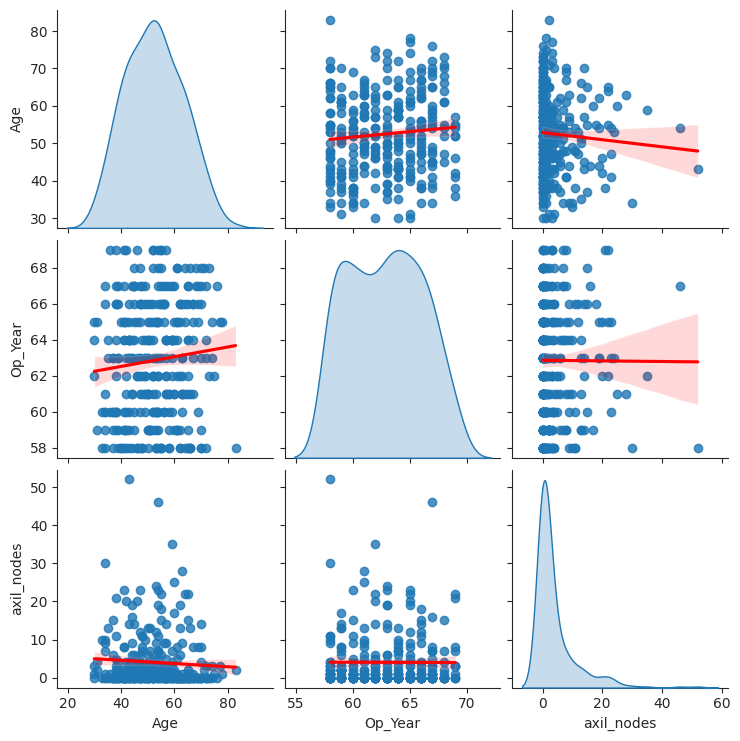

In [3]:
sb.pairplot(df.drop('Surv_status', axis=1), kind='reg', diag_kind='kde', plot_kws={'line_kws': {'color':'red'}})

In [6]:
df['Surv_status'].value_counts()

1    225
2     81
Name: Surv_status, dtype: int64

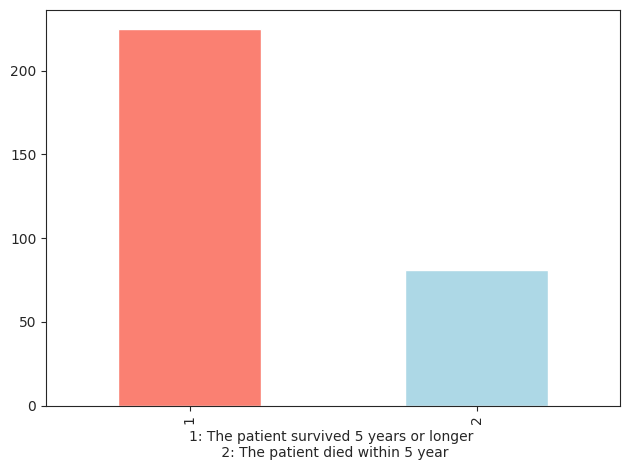

In [9]:
df['Surv_status'].value_counts().plot(kind='bar', color=['salmon', 'lightblue'])
plt.xlabel('1: The patient survived 5 years or longer \n 2: The patient died within 5 year')
plt.tight_layout()
plt.show()

## Data Preprocessing

### Determine the Features and Targets

In [3]:
x = df.drop('Surv_status', axis=1).values.astype('float32')
y = df['Surv_status'].values
y = LabelEncoder().fit_transform(y)

### Train & Test Split

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=101)

## Modelling

In [43]:
def plot_training_history(history):
  fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(12, 6))
  ax_loss.plot(history.history['loss'])
  ax_loss.plot(history.history['val_loss'])
  ax_loss.set_title('History of Loss')
  ax_loss.set_xlabel('Epochs')
  ax_loss.set_ylabel('Loss')
  ax_loss.legend(['Training', 'Validation'], loc='upper right')
    
  ax_acc.plot(history.history['accuracy'])
  ax_acc.plot(history.history['val_accuracy'])
  ax_acc.set_title('History of Accuracy')
  ax_acc.set_xlabel('Epochs')
  ax_acc.set_ylabel('Accuracy')
  ax_acc.legend(['Training', 'Validation'], loc='lower right')
    
  plt.tight_layout()
  plt.show()

In [4]:
n_features = x.shape[1]
max_epochs = 200

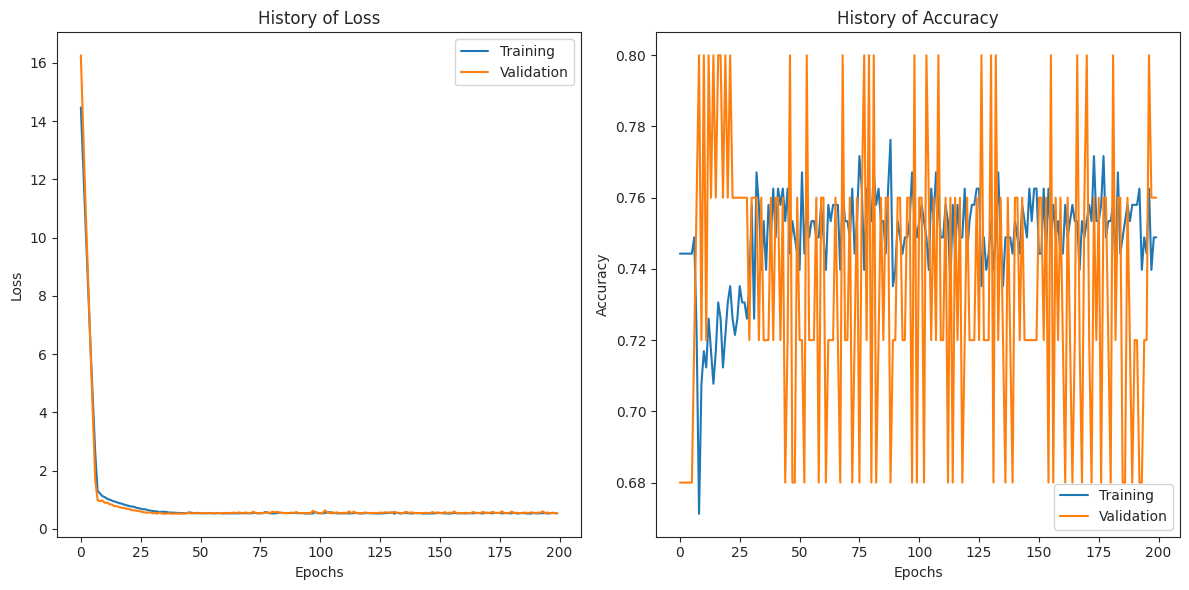

In [45]:
model = Sequential()
model.add(Dense(10, activation='relu', input_shape=(n_features, )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=max_epochs, batch_size=16, 
                    verbose=0, validation_split=0.1)

plot_training_history(history)

In [46]:
y_pred = model.predict(x_test, verbose=0)

acc = accuracy_score(y_test, np.argmax(y_pred, axis=1)) * 100

print('Accuracy: {0:.2f}%'.format(acc))

Accuracy: 72.58%


In [65]:
nr_folds = 10
kfold = StratifiedKFold(nr_folds, shuffle=True, random_state=101)

scores = list()
counter = 1
for train_ix, test_ix in kfold.split(x, y):
  # split data
  x_train, x_test, y_train, y_test = x[train_ix], x[test_ix], y[train_ix], y[test_ix]

  model = Sequential()
  model.add(Dense(10, activation='relu', input_shape=(n_features, )))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  model.fit(x_train, y_train, epochs=max_epochs, batch_size=16, 
                    verbose=0, validation_split=0.1)
  
  y_pred = model.predict(x_test, verbose=0)

  acc = accuracy_score(y_test, np.argmax(y_pred, axis=1)) * 100
  scores.append(acc)
  print('> Fold %d / %d - Accuracy: %.2f%%' % (counter, nr_folds, acc))
  counter =+ 1

print('--------------------------------')
print('Mean Accuracy: %.2f%% (%.2f)' % (np.mean(scores), np.std(scores)))

> Fold 1 / 10 - Accuracy: 74.19%
> Fold 1 / 10 - Accuracy: 74.19%
> Fold 1 / 10 - Accuracy: 74.19%
> Fold 1 / 10 - Accuracy: 74.19%


KeyboardInterrupt: ignored

In [9]:
nr_folds = 10
kfold = StratifiedKFold(nr_folds, shuffle=True, random_state=101)

scores = list()
counter = 1
for train_ix, test_ix in kfold.split(x, y):
  # split data
  x_train, x_test, y_train, y_test = x[train_ix], x[test_ix], y[train_ix], y[test_ix]

  early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

  model = Sequential()
  model.add(Dense(10, activation='relu', input_shape=(n_features, )))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  model.fit(x_train, y_train, epochs=max_epochs, batch_size=16, 
                    verbose=0, validation_split=0.1, callbacks=[early_stop])
  
  y_pred = model.predict(x_test, verbose=0)

  acc = accuracy_score(y_test, np.argmax(y_pred, axis=1)) * 100
  scores.append(acc)
  print('> Fold %d / %d - Accuracy: %.2f%%' % (counter, nr_folds, acc))
  counter =+ 1

print('--------------------------------')
print('Mean Accuracy: %.2f%% (%.2f)' % (np.mean(scores), np.std(scores)))

Epoch 6: early stopping
> Fold 1 / 10 - Accuracy: 74.19%
Epoch 29: early stopping
> Fold 1 / 10 - Accuracy: 74.19%
Epoch 7: early stopping
> Fold 1 / 10 - Accuracy: 74.19%
Epoch 11: early stopping
> Fold 1 / 10 - Accuracy: 74.19%
Epoch 97: early stopping
> Fold 1 / 10 - Accuracy: 74.19%
Epoch 16: early stopping
> Fold 1 / 10 - Accuracy: 70.97%
Epoch 8: early stopping
> Fold 1 / 10 - Accuracy: 73.33%
Epoch 10: early stopping
> Fold 1 / 10 - Accuracy: 73.33%
Epoch 8: early stopping
> Fold 1 / 10 - Accuracy: 73.33%
Epoch 15: early stopping
> Fold 1 / 10 - Accuracy: 73.33%
--------------------------------
Mean Accuracy: 73.53% (0.94)
